In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist


num_classes = 10  # загальна кількість класів
num_features = 784  # кількість атрибутів вхідного вектора

learning_rate = 0.001  # швидкість навчання
training_steps = 3000  # максимальне число кроків
batch_size = 256  # розмір пакету
display_step = 100  # кожні 100 кроків показуємо прогрес

n_hidden_1 = 128  # кількість нейронів 1-го шару
n_hidden_2 = 256  # кількість нейронів 2-го шару

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо на float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо зображення в вектори
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255.0, x_test / 255.0

# Перемішуємо та підготовлюємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Мережа з двома прихованими шарами
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        initializer = tf.keras.initializers.HeNormal()  # Ініціалізація вагів методом He
        self.w = tf.Variable(initializer([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=None):
        y = tf.matmul(x, self.w) + self.b
        if activation:
            return activation(y)
        return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар з Dropout
        self.layer1 = DenseLayer(num_features, 256)  # збільшили кількість нейронів
        self.dropout1 = tf.keras.layers.Dropout(0.5)  # Dropout з 50% ймовірністю
        # Другий шар з Dropout
        self.layer2 = DenseLayer(256, 512)  # більше нейронів у другому шарі
        self.dropout2 = tf.keras.layers.Dropout(0.5)  # Dropout
        # Вихідний шар
        self.layer3 = DenseLayer(512, num_classes)

    def __call__(self, x, training=False):
        x = self.layer1(x, activation=tf.nn.relu)
        if training:
            x = self.dropout1(x, training=training)  # Використовуємо Dropout тільки під час тренування
        x = self.layer2(x, activation=tf.nn.relu)
        if training:
            x = self.dropout2(x, training=training)
        x = self.layer3(x)
        return tf.nn.softmax(x)

# Створюємо екземпляр нейронної мережі
neural_net = NN()

# Функція для обчислення функції втрат (крос-ентропія)
def cross_entropy_loss(y_pred, y_true):
    # Перетворюємо мітки y_true в one-hot формат
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Крос-ентропійна функція втрат
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
    return loss

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_pred_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(y_pred_classes, tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


# Оптимізатор (Adam)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Тренування моделі
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    with tf.GradientTape() as tape:
        # Передбачення (з Dropout під час навчання)
        pred = neural_net(batch_x, training=True)
        # Обчислення втрат
        loss = cross_entropy_loss(pred, batch_y)

    # Обчислення та застосування градієнтів
    gradients = tape.gradient(loss, neural_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

    if step % display_step == 0:
        # Під час оцінювання Dropout не використовується
        pred_eval = neural_net(batch_x, training=False)
        acc = accuracy(pred_eval, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Step 100, Loss: 2.0574, Accuracy: 0.6367
Step 200, Loss: 1.7989, Accuracy: 0.7734
Step 300, Loss: 1.7580, Accuracy: 0.7852
Step 400, Loss: 1.6713, Accuracy: 0.8633
Step 500, Loss: 1.6725, Accuracy: 0.8633
Step 600, Loss: 1.6625, Accuracy: 0.8359
Step 700, Loss: 1.6303, Accuracy: 0.8945
Step 800, Loss: 1.6131, Accuracy: 0.9180
Step 900, Loss: 1.6314, Accuracy: 0.8711
Step 1000, Loss: 1.6353, Accuracy: 0.8945
Step 1100, Loss: 1.5951, Accuracy: 0.8984
Step 1200, Loss: 1.6076, Accuracy: 0.8906
Step 1300, Loss: 1.6061, Accuracy: 0.9102
Step 1400, Loss: 1.5819, Accuracy: 0.8984
Step 1500, Loss: 1.5925, Accuracy: 0.8867
Step 1600, Loss: 1.5924, Accuracy: 0.9102
Step 1700, Loss: 1.5554, Accuracy: 0.9258
Step 1800, Loss: 1.5462, Accuracy: 0.9297
Step 1900, Loss: 1.5535, Accuracy: 0.9414
Step 2000, Loss: 1.5194, Accuracy: 0.9609
Step 2100, Loss: 1.5463, Accuracy: 0.9258
Step 2200, Loss: 1.5625, Accuracy: 0.9180
Step 2300, Loss: 1.5510, Accuracy: 0.9375
Step 2400, Loss: 1.5528, Accuracy: 0.9492
S

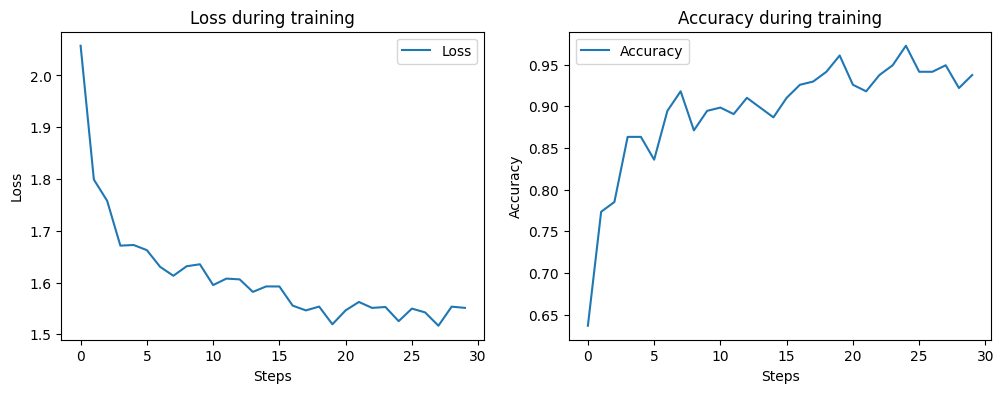

In [2]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись
 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Loss during training')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
import time
# Обчисліть точність навченої нейромережі
# Функція для обчислення точності на тренувальних даних
def evaluate_model(neural_net, dataset, max_batches=None):
    total_correct = 0
    total_samples = 0
    batch_count = 0
    
    start_time = time.time()  # Початок вимірювання часу
    
    for batch_x, batch_y in dataset:
        # Передбачення для кожного батчу
        predictions = neural_net(batch_x)
        # Визначаємо передбачені класи
        predicted_classes = tf.argmax(predictions, axis=1)
        # Перетворення міток у тип int64
        batch_y = tf.cast(batch_y, tf.int64)
        # Підраховуємо правильні передбачення
        correct_predictions = tf.reduce_sum(tf.cast(predicted_classes == batch_y, tf.float32))
        total_correct += correct_predictions
        total_samples += batch_x.shape[0]
        
        batch_count += 1
        # Якщо вказано max_batches, зупиняємо виконання після обробки max_batches батчів
        if max_batches and batch_count >= max_batches:
            break

    end_time = time.time()  # Кінець вимірювання часу
    print(f"Time taken: {end_time - start_time:.2f} seconds for {batch_count} batches")

    # Обчислення точності
    accuracy = total_correct / total_samples
    return accuracy.numpy()

In [15]:
# Оцінка точності на тренувальних даних для перших 100 батчів
train_accuracy = evaluate_model(neural_net, train_data, max_batches=10000)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

Time taken: 125.16 seconds for 10000 batches
Train Accuracy: 94.58%


In [16]:
# Тестування моделі на тестових даних
# Перетворюємо тестові дані на відповідний формат і робимо передбачення
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Обчислюємо точність моделі на тестових даних
test_accuracy = evaluate_model(neural_net, test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Time taken: 0.53 seconds for 40 batches
Test Accuracy: 94.41%


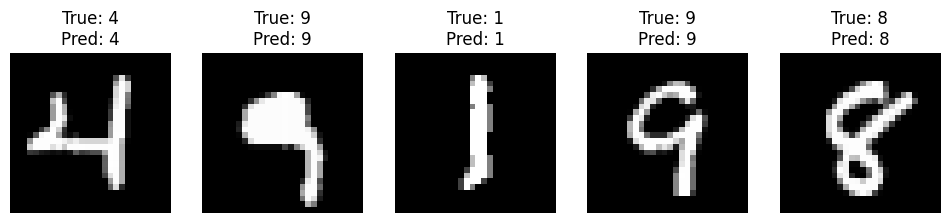

Accuracy on 5 random images: 100.00%


In [22]:
# Функція для візуалізації тестових зображень і передбачень моделі
def test_random_images(model, test_data, num_images=5):
    # Отримання батчу тестових даних
    images, labels = next(iter(test_data))
    
    # Вибір 5 випадкових індексів
    random_indices = random.sample(range(images.shape[0]), num_images)
    
    plt.figure(figsize=(12, 6))  # Створення фігури для зображень
    
    for i, idx in enumerate(random_indices):
        image = images[idx].numpy().reshape(28, 28)  # Перетворення у формат 28x28
        label = labels[idx].numpy()

        # Передбачення нейронної мережі
        reshaped_image = images[idx].numpy().reshape(1, -1)  # Перетворення в 1D масив (784,)
        prediction = model(reshaped_image)  # Передбачення моделі
        predicted_class = np.argmax(prediction, axis=1)[0]

        # Виведення зображення
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')  # Відображення зображення у відтінках сірого
        plt.title(f"True: {label}\nPred: {predicted_class}")
        plt.axis('off')
    
    plt.show()

    # Оцінка того, як часто модель помиляється
    correct_predictions = 0
    for idx in random_indices:
        image = images[idx].numpy().reshape(1, -1)  # Перетворення на одномірний масив
        label = labels[idx].numpy()
        prediction = model(image)  # Передбачення моделі
        predicted_class = np.argmax(prediction, axis=1)[0]
        
        if predicted_class == label:
            correct_predictions += 1

    accuracy = correct_predictions / num_images
    print(f"Accuracy on {num_images} random images: {accuracy * 100:.2f}%")

# Припускаємо, що `test_data` - це тестова вибірка, а `neural_net` - навчена модель
test_random_images(neural_net, test_data)